In [1]:
import os

# Use the eager mode
os.environ['PT_HPU_LAZY_MODE'] = '0'

# Verify the environment variable is set
print(f"PT_HPU_LAZY_MODE: {os.environ['PT_HPU_LAZY_MODE']}")

import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

import habana_frameworks.torch.core as htcore

PT_HPU_LAZY_MODE: 0


Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)


2.4.0a0+git74cd574


/usr/lib/python3.10/inspect.py:288: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(object, types.FunctionType)


In [2]:
import numpy as np
import torch
import torch_geometric.datasets as datasets
import torch_geometric.data as data
import torch_geometric.transforms as transforms
import networkx as nx
from torch_geometric.utils.convert import to_networkx

## Data Handling in PyG

### Data

Let's create a dummy graph

In [3]:
# use rich traceback

from rich import traceback
traceback.install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7fa198aa8820>>

In [4]:
device = torch.device("hpu")

In [5]:
embeddings = torch.rand((100, 16), dtype=torch.float, device=device)

============================= HABANA PT BRIDGE CONFIGURATION =========================== 
 PT_HPU_LAZY_MODE = 0
 PT_RECIPE_CACHE_PATH = 
 PT_CACHE_FOLDER_DELETE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = 
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 2113407800 KB
------------------------------------------------------------------------------


In [6]:
rows = np.random.choice(100, 500)
cols = np.random.choice(100, 500)
edges = torch.tensor([rows, cols], device=device, dtype=torch.long)

/tmp/ipykernel_2581085/688213010.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /npu-stack/pytorch-fork/torch/csrc/utils/tensor_new.cpp:278.)
  edges = torch.tensor([rows, cols], device=device, dtype=torch.long)


In [7]:
edges_attr = np.random.choice(3,500)

In [8]:
ys = torch.rand((100), device=device).round().long()

Convert the graph information into a PyG Data object

In [9]:
graph = data.Data(x=embeddings, edge_index=edges, edge_attr=edges_attr, y=ys)

In [10]:
graph

Data(x=[100, 16], edge_index=[2, 500], edge_attr=[500], y=[100])

Let's visualize the information contained in the data object

In [11]:
for prop in graph:
    print(prop)

('x', tensor([[0.2015, 0.0336, 0.4447,  ..., 0.9962, 0.6824, 0.7030],
        [0.0730, 0.4355, 0.4084,  ..., 0.4465, 0.2527, 0.4666],
        [0.7127, 0.1017, 0.6329,  ..., 0.7203, 0.9528, 0.3109],
        ...,
        [0.3192, 0.7743, 0.4929,  ..., 0.5407, 0.2032, 0.1136],
        [0.8586, 0.2969, 0.1156,  ..., 0.4105, 0.6511, 0.1911],
        [0.8849, 0.9036, 0.8528,  ..., 0.0147, 0.5397, 0.9774]],
       device='hpu:0'))
('edge_index', tensor([[68, 35, 30, 90, 58, 85, 54, 34, 28, 36, 82, 24, 93, 72, 15, 68, 80, 65,
         97, 88, 38, 16, 98, 69, 46, 41, 53, 74,  0, 17,  9, 72, 18, 69, 20, 81,
         20, 76, 86, 20, 26, 87, 68, 79, 50, 65, 57, 30, 43, 91,  7,  6, 59, 54,
          0, 93, 53,  8, 53, 84, 28, 19, 29, 82, 71, 33, 45,  7, 55, 54, 18, 97,
          3, 20, 32,  3, 63,  3, 17, 75, 78, 79, 37, 71, 18, 65, 29, 77, 12, 99,
         73, 13, 87, 93,  3, 99, 78, 88, 77, 11, 75, 18, 23, 11, 24, 89, 16, 46,
         30, 38, 31, 61, 26, 68, 50, 61, 11, 82, 16, 68, 74,  4,  8, 36

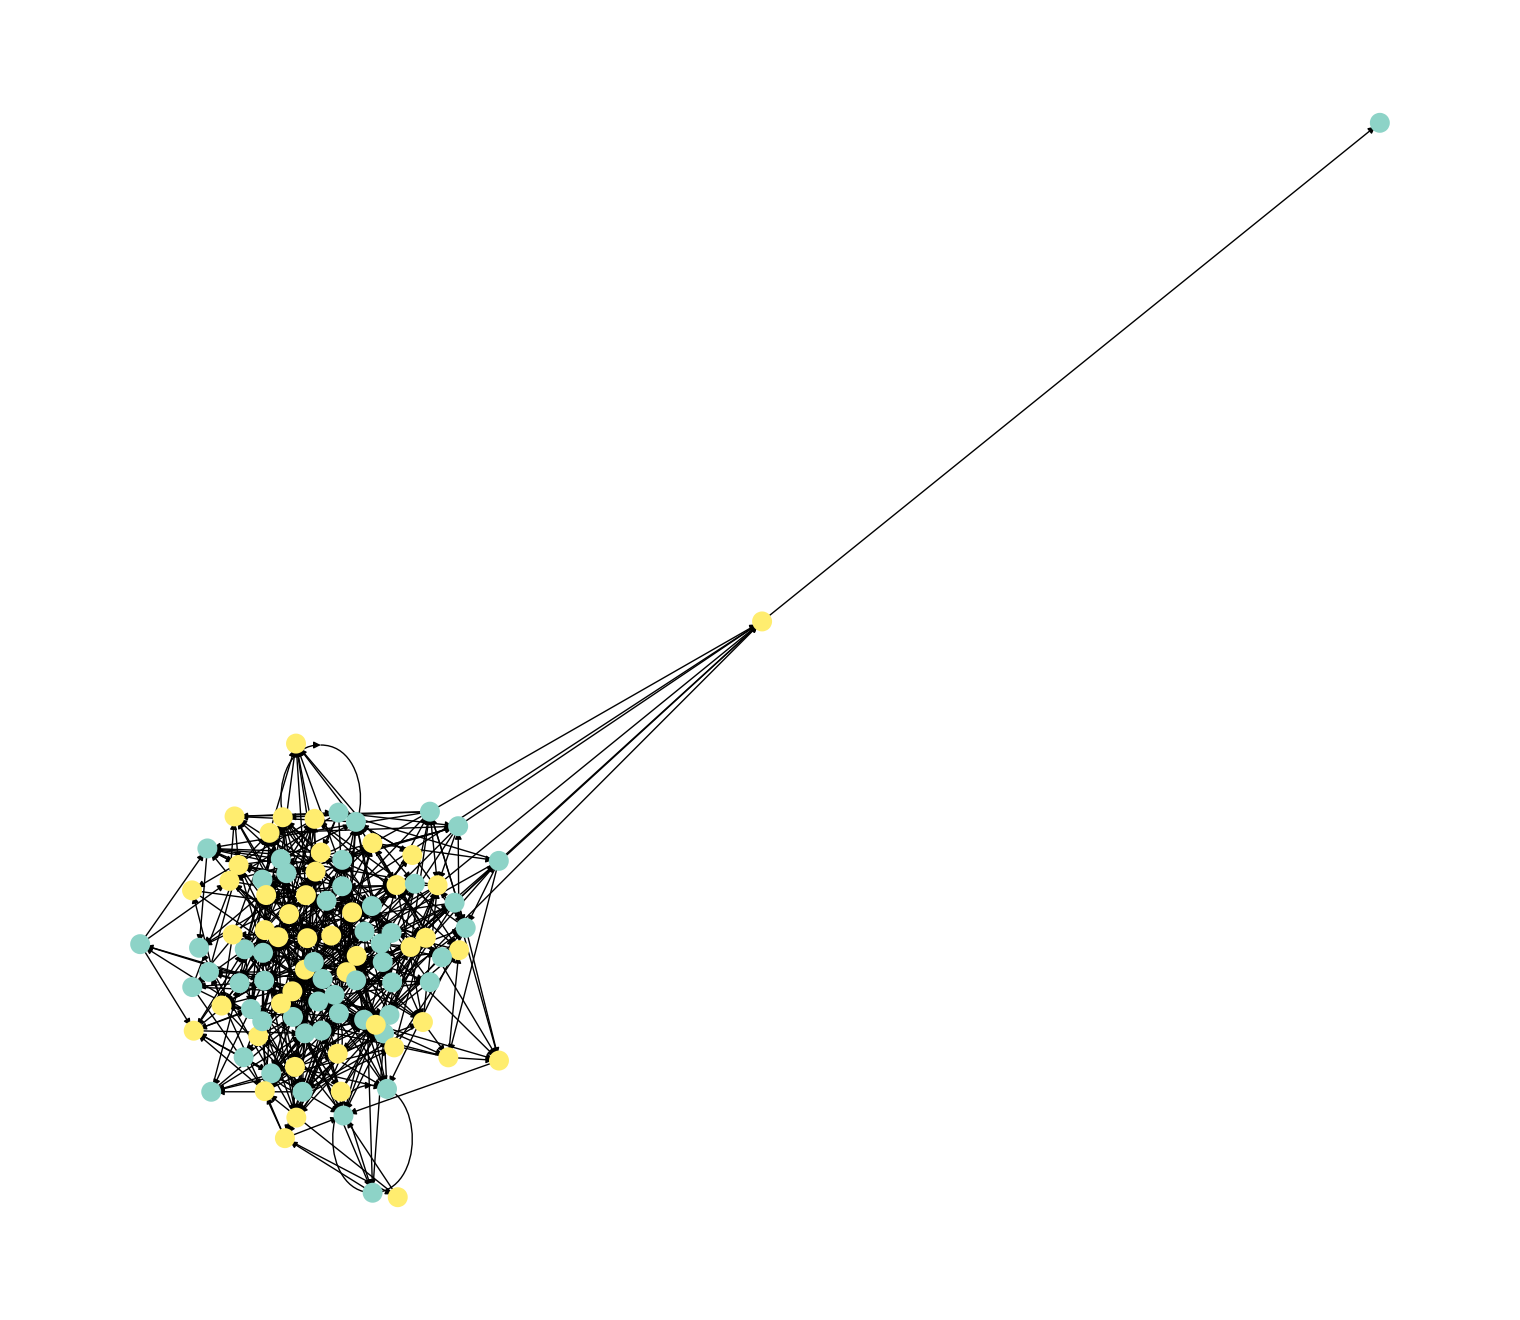

In [13]:
vis = to_networkx(graph)

node_labels = graph.y.cpu().numpy()

import matplotlib.pyplot as plt
plt.figure(1,figsize=(15,13)) 
nx.draw(vis, cmap=plt.get_cmap('Set3'),node_color = node_labels,node_size=70,linewidths=6)
plt.show()

### Batch

With the Batch object we can represent multiple graphs as a single disconnected graph

In [14]:
graph2 = graph

In [15]:
batch = data.Batch().from_data_list([graph, graph2])

In [16]:
print("Number of graphs:",batch.num_graphs)
print("Graph at index 1:",batch[1])
print("Retrieve the list of graphs:\n",len(batch.to_data_list()))

Number of graphs: 2
Graph at index 1: Data(x=[100, 16], edge_index=[2, 500], edge_attr=[500], y=[100])
Retrieve the list of graphs:
 2


### Cluster

ClusterData groups the nodes of a graph into a specific number of cluster for faster computation in large graphs, then use ClusterLoader to load batches of clusters

In [17]:
cluster = data.ClusterData(graph, 5)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.ClusterData' is deprecated, use 'loader.ClusterData' instead
  warnings.warn(out)
Computing METIS partitioning...


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 cluster = data.ClusterData(graph, 5)                                                         │
│   2                                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:27 in wrapper             │
│                                                                                                  │
│   24 │   │   │   if details is not None:                                                         │
│   25 │   │   │   │   out += f", {details}"                                                       │
│   26 │   │   │   warnings.warn(out)                                                              │
│ ❱ 27 │   │   │   return func(*args, **kwargs)                                                    │
│   28 │   │                                                                                       │
│   29 │   │   return wrapper                                                                      │
│   30                                                                                             │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch_geometric/loader/cluster.py:86 in __init__         │
│                                                                                                  │
│    83 │   │   │   if log:  # pragma: no cover                                                    │
│    84 │   │   │   │   print('Computing METIS partitioning...', file=sys.stderr)                  │
│    85 │   │   │                                                                                  │
│ ❱  86 │   │   │   cluster = self._metis(data.edge_index, data.num_nodes)                         │
│    87 │   │   │   self.partition = self._partition(data.edge_index, cluster)                     │
│    88 │   │   │                                                                                  │
│    89 │   │   │   if save_dir is not None:                                                       │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch_geometric/loader/cluster.py:132 in _metis          │
│                                                                                                  │
│   129 │   │   │   ).to(edge_index.device)                                                        │
│   130 │   │                                                                                      │
│   131 │   │   if cluster is None:                                                                │
│ ❱ 132 │   │   │   raise ImportError(f"'{self.__class__.__name__}' requires either "              │
│   133 │   │   │   │   │   │   │     f"'pyg-lib' or 'torch-sparse'")                              │
│   134 │   │                                                                                      │
│   135 │   │   return cluster                                                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ImportError: 'ClusterData' requires either 'pyg-lib' or 'torch-sparse'

In [18]:
clusterloader = data.ClusterLoader(cluster)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 clusterloader = data.ClusterLoader(cluster)                                                  │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'cluster' is not defined

### Sampler

For each convolutional layer, sample a maximum of nodes from each neighborhood (as in GraphSAGE)

In [40]:
sampler = data.NeighborSampler(graph.edge_index, sizes=[3,10], batch_size=4,
                                  shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.NeighborSampler' is deprecated, use 'loader.NeighborSampler' instead
  warnings.warn(out)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 sampler = data.NeighborSampler(graph.edge_index, sizes=[3,10], batch_size=4,                 │
│   2 │   │   │   │   │   │   │   │     shuffle=False)                                             │
│   3                                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:27 in wrapper             │
│                                                                                                  │
│   24 │   │   │   if details is not None:                                                         │
│   25 │   │   │   │   out += f", {details}"                                                       │
│   26 │   │   │   warnings.warn(out)                                                              │
│ ❱ 27 │   │   │   return func(*args, **kwargs)                                                    │
│   28 │   │                                                                                       │
│   29 │   │   return wrapper                                                                      │
│   30                                                                                             │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch_geometric/loader/neighbor_sampler.py:147 in        │
│ __init__                                                                                         │
│                                                                                                  │
│   144 │   │   │   │   num_nodes = int(edge_index.max()) + 1                                      │
│   145 │   │   │                                                                                  │
│   146 │   │   │   value = torch.arange(edge_index.size(1)) if return_e_id else None              │
│ ❱ 147 │   │   │   self.adj_t = SparseTensor(row=edge_index[0], col=edge_index[1],                │
│   148 │   │   │   │   │   │   │   │   │     value=value,                                         │
│   149 │   │   │   │   │   │   │   │   │     sparse_sizes=(num_nodes, num_nodes)).t()             │
│   150 │   │   else:                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:163 in __init__                │
│                                                                                                  │
│   160 │   │   │   is_sorted: bool = False,                                                       │
│   161 │   │   │   trust_data: bool = False,                                                      │
│   162 │   │   ):                                                                                 │
│ ❱ 163 │   │   │   raise ImportError("'SparseTensor' requires 'torch-sparse'")                    │
│   164 │   │                                                                                      │
│   165 │   │   @classmethod                                                                       │
│   166 │   │   def from_edge_index(                                                               │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ImportError: 'SparseTensor' requires 'torch-sparse'

In [ ]:
for s in sampler:
    print(s)
    break

In [ ]:
print("Batch size:", s[0])
print("Number of unique nodes involved in the sampling:",len(s[1]))
print("Number of neighbors sampled:", len(s[2][0].edge_index[0]), len(s[2][1].edge_index[0]))

### Datasets

List all the available datasets

In [ ]:
datasets.__all__

In [ ]:
name = 'Cora'
transform = transforms.Compose([
    transforms.AddTrainValTestMask('train_rest', num_val=500, num_test=500),
    transforms.TargetIndegree(),
])
cora = datasets.Planetoid('./data', name, pre_transform=transforms.NormalizeFeatures(), transform=transform)

In [ ]:
aids = datasets.TUDataset(root="./data", name="AIDS")

In [ ]:
print("AIDS info:")
print('# of graphs:', len(aids))
print('# Classes (graphs)', aids.num_classes)
print('# Edge features', aids.num_edge_features)
print('# Edge labels', aids.num_edge_labels)
print('# Node features', aids.num_node_features)

In [ ]:
print("Cora info:")
print('# of graphs:', len(cora))
print('# Classes (nodes)', cora.num_classes)
print('# Edge features', cora.num_edge_features)
print('# Node features', cora.num_node_features)

In [ ]:
aids.data

In [ ]:
aids[0]

In [ ]:
cora.data

In [ ]:
cora[0]

In [ ]:
cora_loader = data.DataLoader(cora)

In [ ]:
for l in cora_loader:
    print(l)
    break